In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

# IMPORTS

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import scikitplot as skplt
import xgboost as xgb


from matplotlib import pyplot as plt
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## HELPER FUNCTIONS

In [3]:
def jupyter_settings():
    %matplotlib notebook
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:75% !important; }</style>') )
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings

<function __main__.jupyter_settings()>

## Loading Dataset

In [5]:
df_raw = pd.read_csv('data/raw/train.csv')

In [6]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# DATA OVERVIEW

In [7]:
df1 = df_raw.copy()

## RENAME COLUMNS

In [8]:
cols_new = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

cols_new = list(map(lambda x: x.lower(), cols_new))
df1.columns = cols_new

df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## DATA DIMENSION

In [9]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 381109
Number of Columns: 12


## DATA TYPES

In [10]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## CHECK NA

In [11]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## DESCRIPTIVE STATISTICS

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### NUMERICAL ATTRIBUTES

In [13]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# FEATURE ENGINEERING

In [14]:
df2 = df1.copy()

In [15]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [16]:
# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: '1' if x == 'Yes' else '0')
df2['vehicle_damage'] = pd.to_numeric(df2['vehicle_damage'])
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_years' if x == '1-2 Year' else 'below_1_year' )

# DATA FILTERING

In [17]:
df3 = df2.copy()

# EDA

In [18]:
df4 = df3.copy()

## UNIVARIATE ANALYSIS

<AxesSubplot: xlabel='response', ylabel='age'>

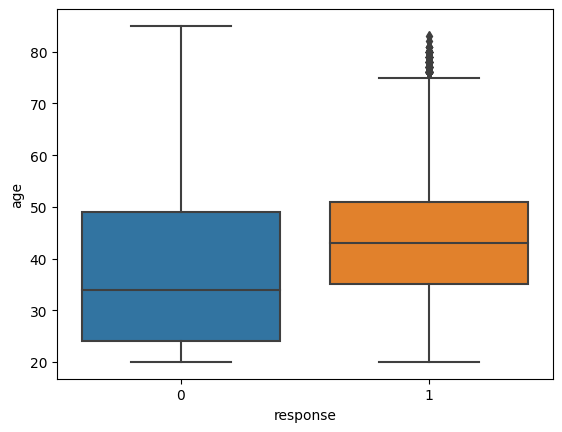

In [19]:
# age
sns.boxplot(x='response', y='age', data=df4)

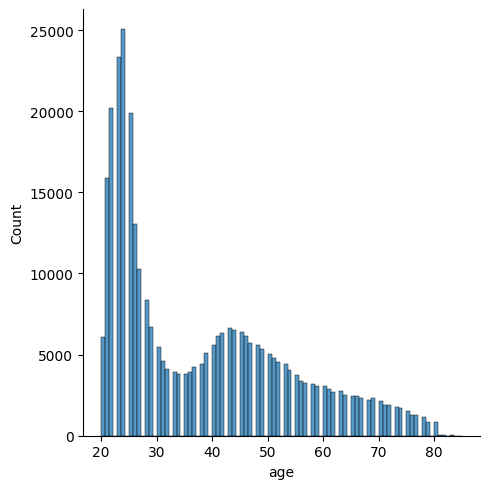

In [20]:
aux00 = df4.loc[df4['response'] == 0, 'age']
sns.displot(aux00)

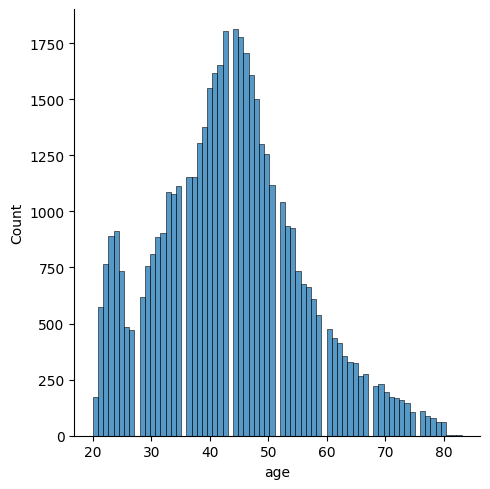

In [21]:
aux00 = df4.loc[df4['response'] == 1, 'age']
sns.displot(aux00)

<AxesSubplot: xlabel='response', ylabel='annual_premium'>

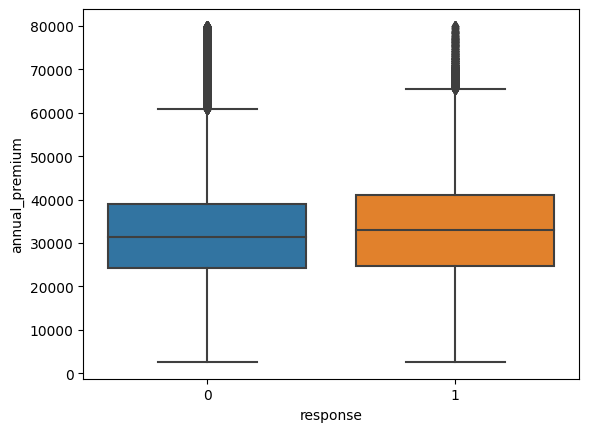

In [22]:
# annual_premium
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', data=aux)

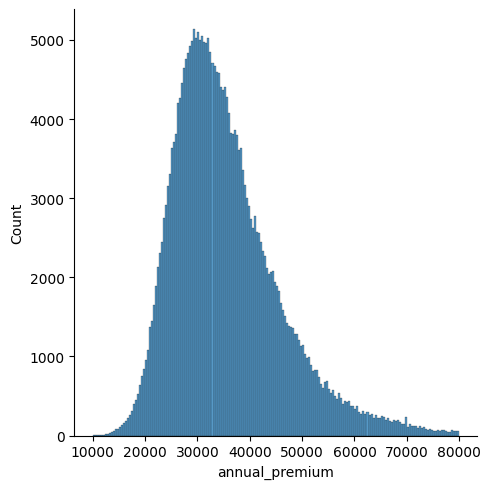

In [23]:
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux00 = aux.loc[df4['response'] == 0, 'annual_premium']
sns.displot(aux00)

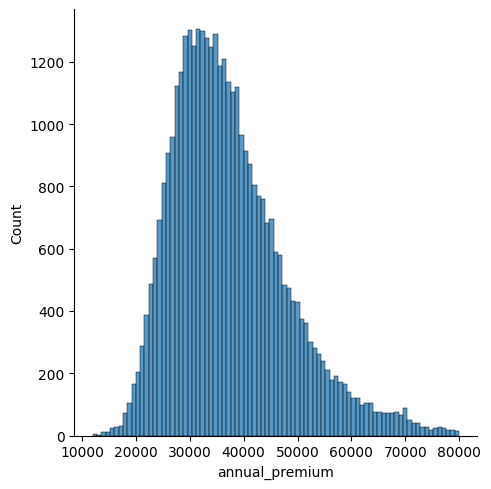

In [24]:
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux00 = aux.loc[df4['response'] == 1, 'annual_premium']
sns.displot(aux00)

<AxesSubplot: xlabel='response', ylabel='driving_license'>

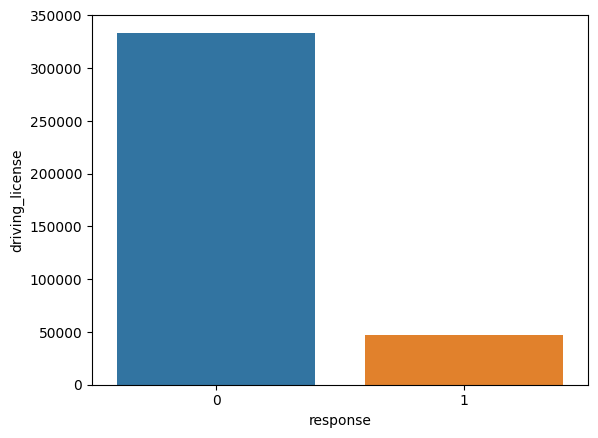

In [25]:
# driving_license
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()

aux['driving_license_per'] = aux['driving_license'] / aux['driving_license'].sum()

sns.barplot(x='response', y='driving_license', data=aux)

<AxesSubplot: xlabel='region_code', ylabel='id'>

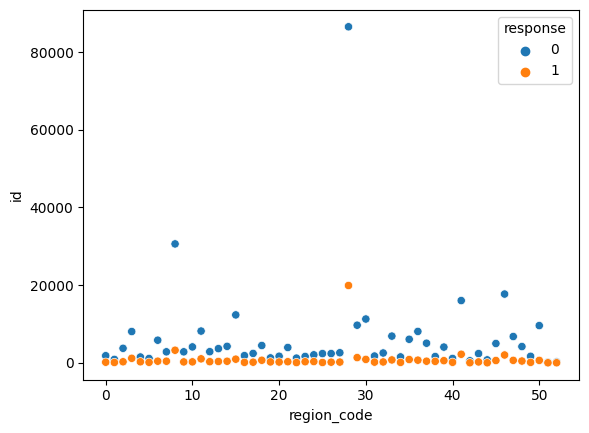

In [26]:
# region_code
aux0 = df4[['id','region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux0)

<AxesSubplot: xlabel='previously_insured', ylabel='id'>

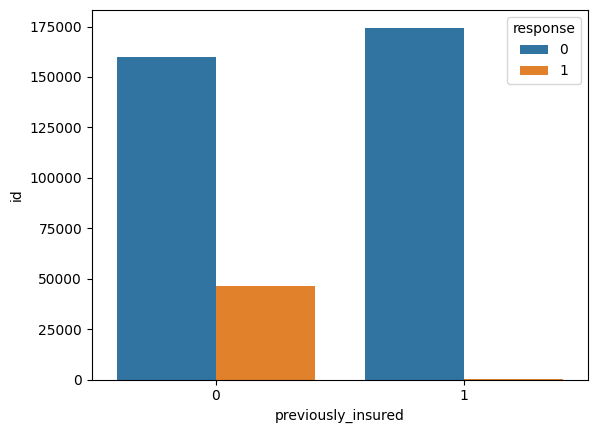

In [27]:
# previously_insured
aux = df4[['id', 'previously_insured', 'response']].groupby(['response', 'previously_insured']).count().reset_index()
sns.barplot(x='previously_insured', y='id', hue='response', data=aux)

In [28]:
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [29]:
# vehicle_age
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,between_1_2_years,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


<AxesSubplot: xlabel='gender', ylabel='id'>

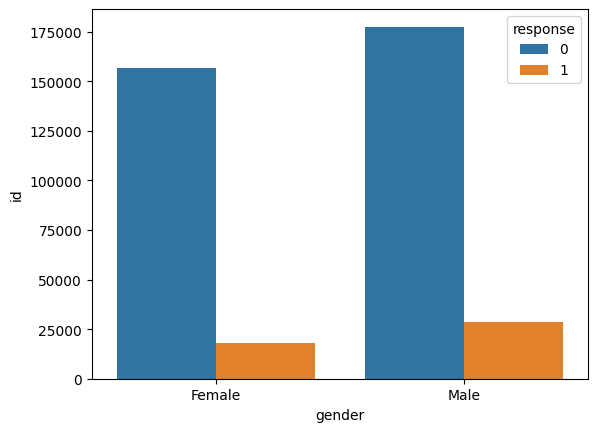

In [30]:
# gender
aux = df4[['id', 'gender', 'response']].groupby(['response', 'gender']).count().reset_index()
sns.barplot(x='gender', y='id', hue='response', data=aux)

In [31]:
pd.crosstab(df4['gender'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
gender,,
Female,0.896098,0.103902
Male,0.861589,0.138411


<AxesSubplot: xlabel='vehicle_damage', ylabel='id'>

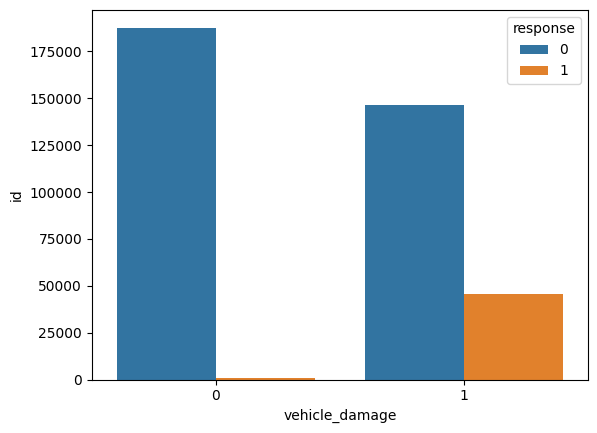

In [32]:
# vehicle_damage
aux = df4[['id', 'vehicle_damage', 'response']].groupby(['response', 'vehicle_damage']).count().reset_index()
sns.barplot(x='vehicle_damage', y='id', hue='response', data=aux)

In [33]:
pd.crosstab(df4['vehicle_damage'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
vehicle_damage,,
0,0.994796,0.005204
1,0.762345,0.237655


<AxesSubplot: xlabel='response', ylabel='policy_sales_channel'>

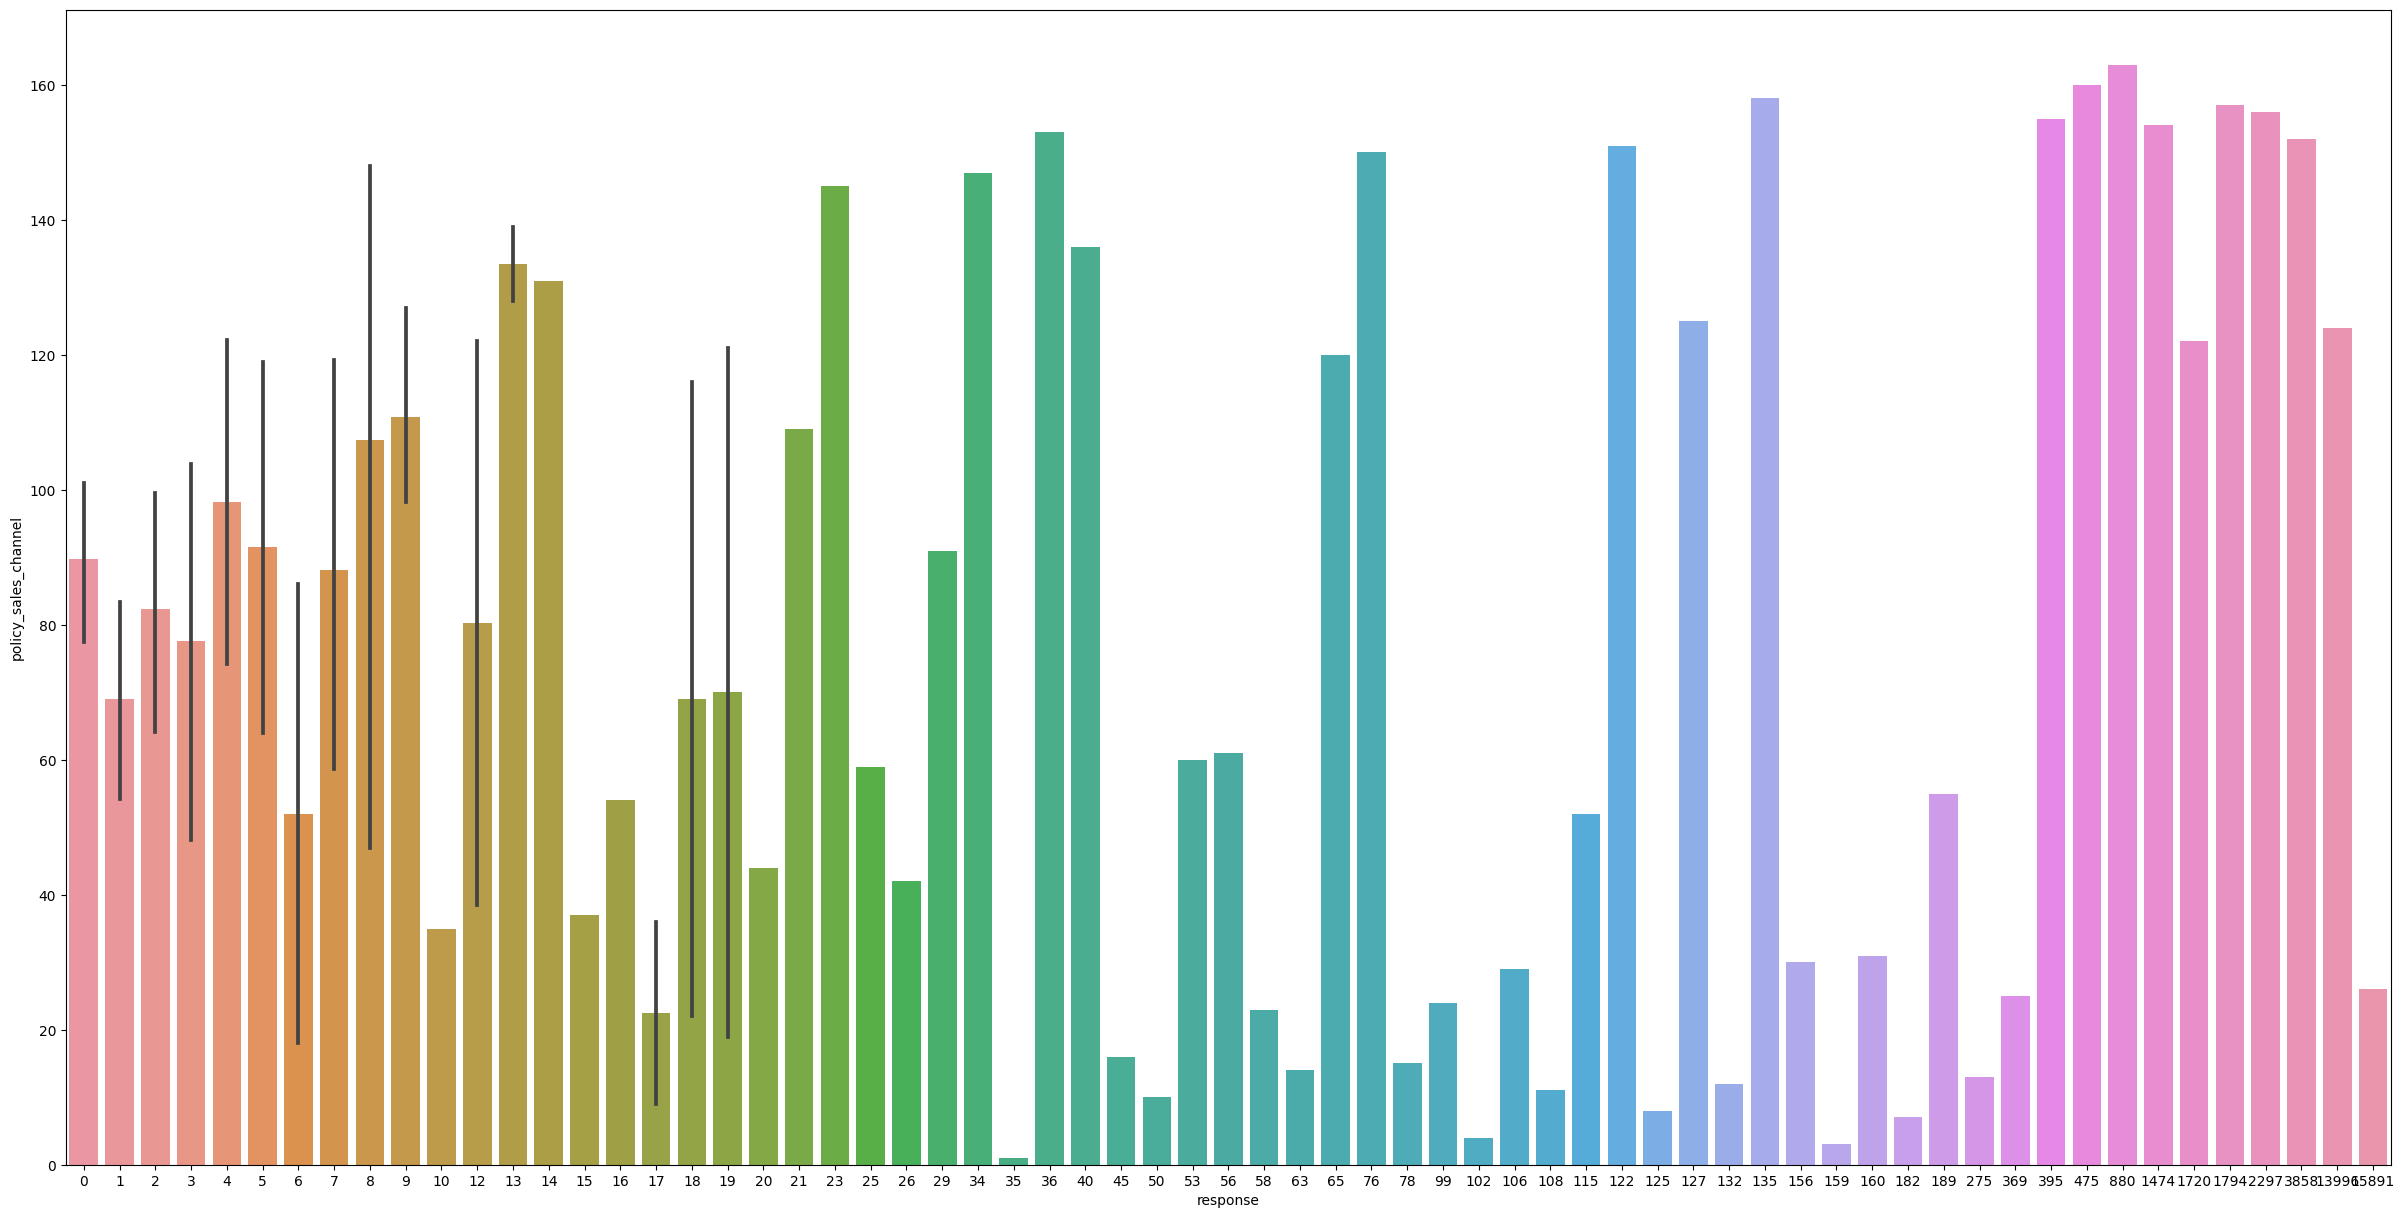

In [34]:
# policy_sales_channel
plt.figure(figsize=(30,15))
aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data=aux)

<AxesSubplot: xlabel='response', ylabel='vintage'>

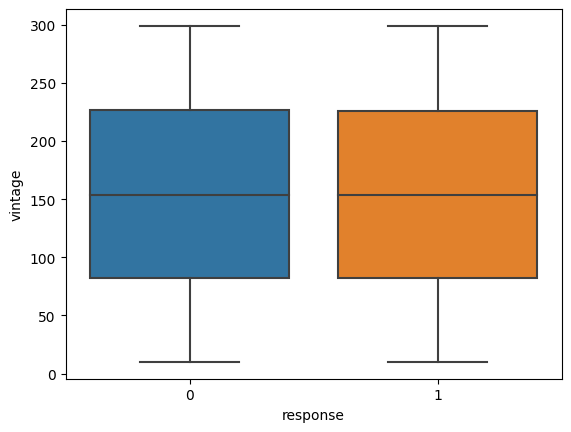

In [35]:
# vintage
sns.boxplot(x='response', y='vintage', data=df4)

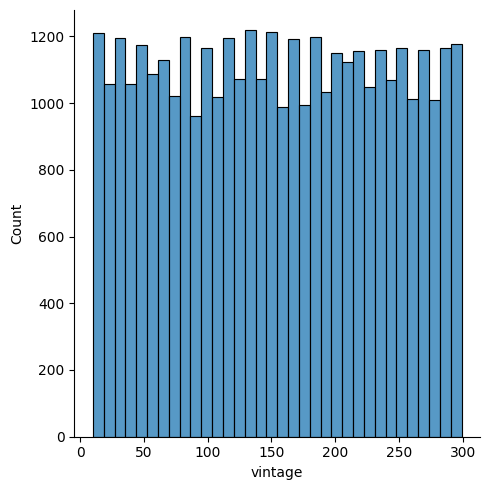

In [36]:
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux00 = aux.loc[df4['response'] == 1, 'vintage']
sns.displot(aux00)

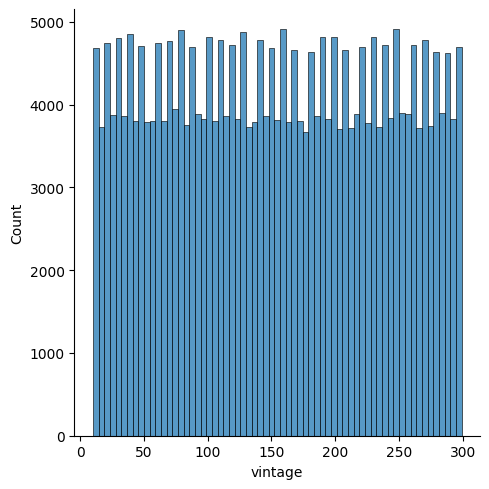

In [37]:
aux00 = aux.loc[df4['response'] == 0, 'vintage']
sns.displot(aux00)

# DATA PREPARATION

In [38]:
df5 = df4.copy()

## DATA SPLITING

In [39]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.20)

df5 = pd.concat([x_train, y_train], axis=1)

## STANDARDIZATION

In [40]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

## RESCALLING

In [41]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)

## ENCODER

In [42]:
# gender - One Hot Encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)

# region_code - Frequency Encoding/ Target Encoding/ Weighted Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)

# vehicle_age - One Hot Encoding/ Order Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Target Encoding/ Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

/tmp/ipykernel_4924/1530954553.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)


## VALIDATION DATA PREPARATION

In [43]:
# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(target_encode_gender)

# age
x_validation.loc[:, 'age'] = mms_age.transform(x_validation[['age']].values)

# region_code
x_validation.loc[:, 'region_code'] = x_validation.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])

# vechile_damage

# annual_premium
x_validation.loc[:, 'annual_premium'] = ss.transform(x_validation[['annual_premium']].values)

# policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)

# vintage
x_validation.loc[:, 'vintage'] = mms_vintage.fit_transform(x_validation[['vintage']].values)

# fillna
x_validation = x_validation.fillna(0)

/tmp/ipykernel_4924/766030943.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(target_encode_gender)


In [45]:
x_validation.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_years,vehicle_age_over_2_years
349076,349077,0.104419,0.815385,1,0.078219,0,1,-1.630823,0.017469,0.314879,0,1,0
246288,246289,0.138769,0.461538,1,0.087261,0,1,0.978926,0.208940,0.048443,0,1,0
77751,77752,0.138769,0.584615,1,0.073361,1,0,-0.244606,0.353305,0.000000,0,1,0
237554,237555,0.138769,0.076923,1,0.154445,0,1,-0.016577,0.007619,0.314879,1,0,0
283122,283123,0.138769,0.353846,1,0.187985,0,1,1.564210,0.208940,0.885813,0,1,0


# FEATURE SELECTION

## FEATURE IMPORTANCE

In [46]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df5.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                         feature  importance
0                        vintage    0.271870
0                 annual_premium    0.243842
0                            age    0.165408
0                    region_code    0.106541
0                 vehicle_damage    0.068563
0           policy_sales_channel    0.059569
0             previously_insured    0.056024
0       vehicle_age_below_1_year    0.013983
0  vehicle_age_between_1_2_years    0.006390
0                         gender    0.004843
0       vehicle_age_over_2_years    0.002446
0                driving_license    0.000521


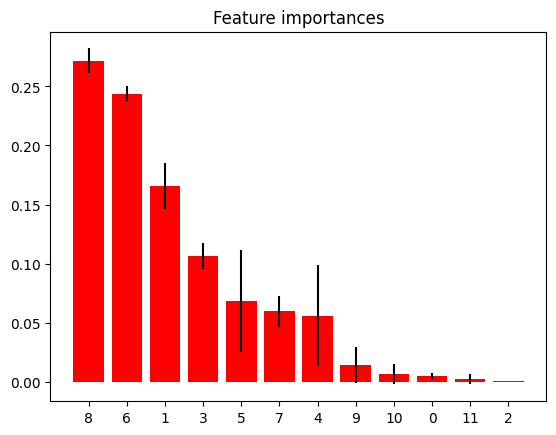

In [47]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

#plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# MACHINE LEARNING MODELLING

In [48]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

x_train = df5[cols_selected]
x_val = x_validation[cols_selected]

## KNN

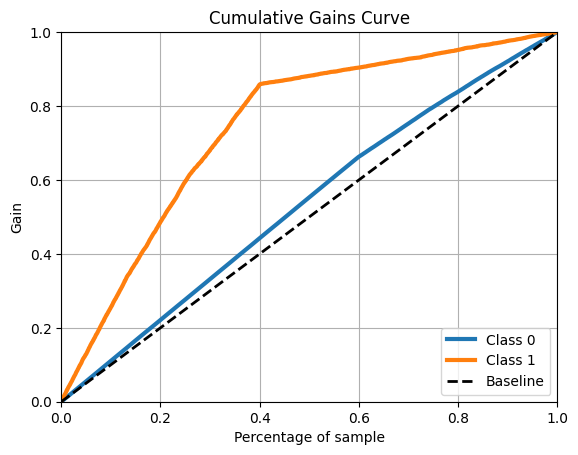

In [50]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train, y_train)

# model prediction - Poder de generalização
yhat_knn = knn_model.predict_proba(x_val)

# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation, yhat_knn);

## LOGISTIC REGRESSION

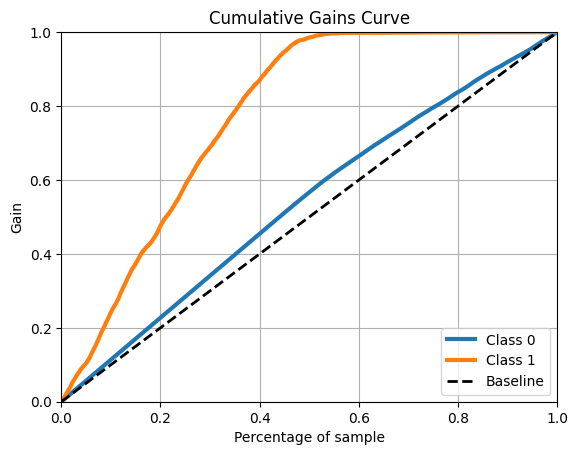

In [51]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_val)

# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lr);

## RANDOM FOREST CLASSIFIER

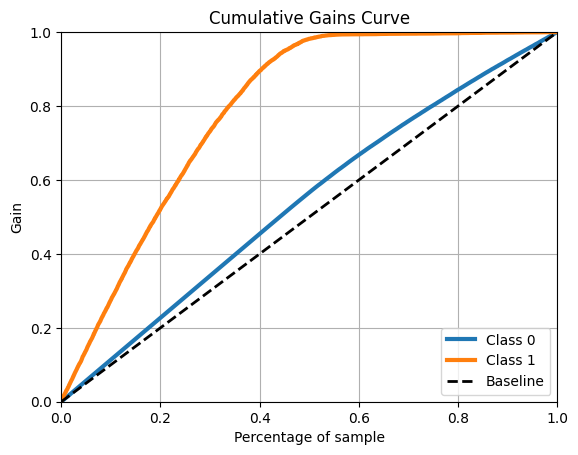

In [52]:
# model definition
rf_model = RandomForestClassifier(n_estimators=250, n_jobs=-1, random_state=42).fit(x_train, y_train)

# model prediction
yhat_rf = rf_model.predict_proba(x_val)

# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation, yhat_rf);

## XGBOOST CLASSIFIER

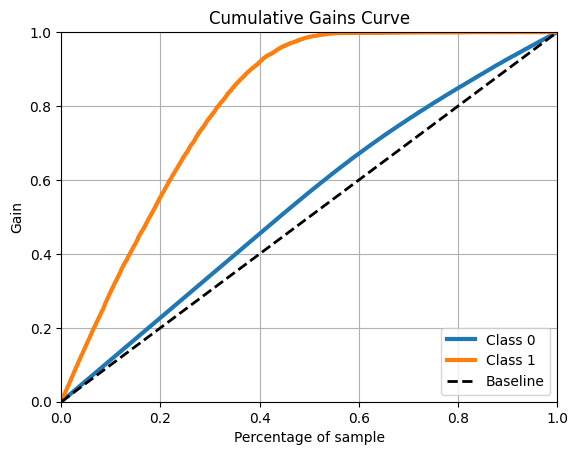

In [53]:
# model definition
xgb_model = XGBClassifier(n_estimators=250, n_jobs=-1, random_state=42).fit(x_train, y_train)

# model prediction
yhat_xgb = xgb_model.predict_proba(x_val)

# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation, yhat_xgb);

## EXTRA TREES CLASSIFIER

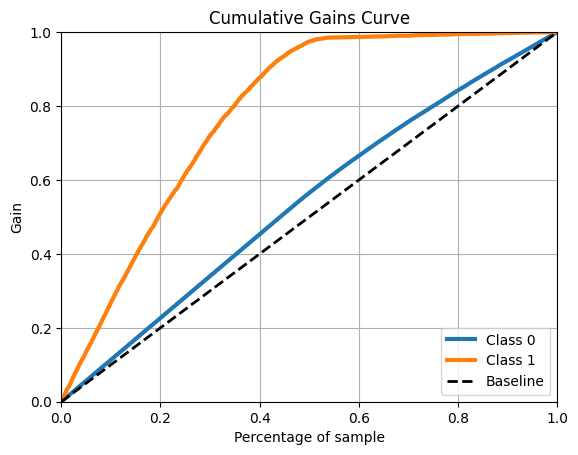

In [54]:
# model definition
et_model = en.ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=42)

# model fit
et_model.fit(x_train, y_train)

# model predict
yhat_et = et_model.predict_proba(x_val)

# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation, yhat_et);

# MODEL PERFORMANCE

In [76]:
def precision_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

In [79]:
def recall_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

In [82]:
# copy data
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = yhat_knn[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values('score', ascending=False)

# compute precision at k
precision_at_50 = precision_at_k(df8, k=50)
print('Precision at k: {}'.format(precision_at_50))

# compute recall at k
recall_at_50 = recall_at_k(df8, k=50)
print('Recall at k: {}'.format(recall_at_50))

Precision at k: 0.39215686274509803
Recall at k: 0.002171788467803236


,id,response,score,ranking
0,68576,1,1.0,1
1,342102,0,1.0,2
2,296339,0,1.0,3
3,191924,0,1.0,4
4,287382,1,1.0,5


In [67]:
 data[['id', 'response', 'score', 'ranking', 'precision_at_k']].head()

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'vehicle_age_below_1_year',
       'vehicle_age_between_1_2_years', 'vehicle_age_over_2_years', 'score'],
      dtype='object')

# HYPERPARAMETER FINE TUNING

# ERROR ANALYSIS

# DEPLOY